# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [577]:
## import pandas as pd
import numpy as np
import math
import json
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.model_selection import RandomizedSearchCV


In [395]:
# read in the json files
portfolio = pd.read_json(r"/Users/rli/Documents/Downloads/new study/udacity/starbuck/portfolio.json", orient='records', lines=True)
profile = pd.read_json(r"/Users/rli/Documents/Downloads/new study/udacity/starbuck/profile.json", orient='records', lines=True)
transcript = pd.read_json(r"/Users/rli/Documents/Downloads/new study/udacity/starbuck/transcript.json", orient='records', lines=True)

In [7]:
portfolio 

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


There are 10 kinds offers. 

In [8]:
profile.shape

(17000, 5)

In [9]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [10]:
transcript.shape

(306534, 4)

In [11]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


# Exploratory Data Analysis¶

`1.` Exploring the profile database, get the general information about the consumers.

In [396]:
#how many customers?
profile[profile.id.isnull()]#check the null value in the id


,gender,age,id,became_member_on,income


In [397]:
print('there are {} customers in the profile'.format(len(profile.id.unique())))

there are 17000 customers in the profile


In [398]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [399]:
profile[profile.gender.isnull()]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In column 'gender', some customers have missing data.

In [400]:
profile[profile.income.isnull()]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [401]:
profile[profile.income.isnull()].gender.value_counts()

Series([], Name: gender, dtype: int64)

In [402]:
profile[profile.income.isnull()].age.value_counts()

118    2175
Name: age, dtype: int64

The customer who has missing data in 'gender' also has missing data in income, and weird age '118'. We can delete these customers, since their data are ambiguous and missing. 

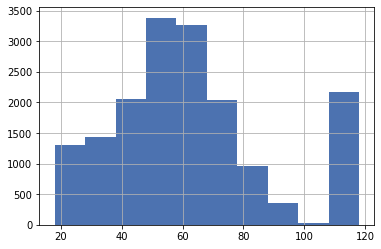

In [403]:
profile.age.hist()

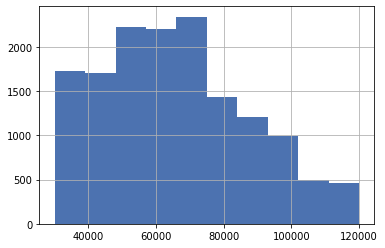

In [404]:
profile.income.hist()

The age 118 are the missing data. The distribution of age and income are both left skewed. The young and mid-age people are the main customers. The low and middle income population are the main customers.

`2.` Exploring the transcript database.

In [32]:
transcript.head(1)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0


In [37]:
transcript.person.nunique()

17000

In [38]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

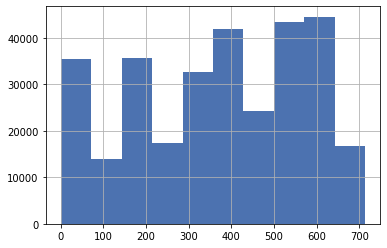

In [341]:
transcript.time.hist()

In [41]:
transcript.value.describe

<bound method NDFrame.describe of 0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object>

In [123]:
#transfer the column 'value' into different columns, since 'value' is a dictionary
temp = transcript['value'].apply(pd.Series)

In [124]:
temp

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...
306529,NaN,1.59,NaN,NaN
306530,NaN,9.53,NaN,NaN
306531,NaN,3.61,NaN,NaN
306532,NaN,3.53,NaN,NaN


In [127]:
#check count of each columns in temp
temp.amount.count()+temp.offer_id.count()+temp.reward.count()+temp['offer id'].count()-len(temp)

33579

In [144]:
temp['offer_id'].count()

33579

In [140]:
temp.reward.count()

33579

In [142]:
# check the rows that with less than three NaN
transcript[temp.isnull().sum(axis = 1)<3]['value'].iloc[1]

{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}

The column 'offer id' is combined with column 'reward'. I will fill the nan value in offer_id column with offer id column.

In [145]:
#fill the offer_id nan with offer id if offer id is not nan
temp['offer_id'] = temp['offer_id'].fillna(temp['offer id']) 
temp = temp.drop('offer id',axis = 1) 

In [146]:
temp.head()

,amount,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [82]:
temp['amount'].describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

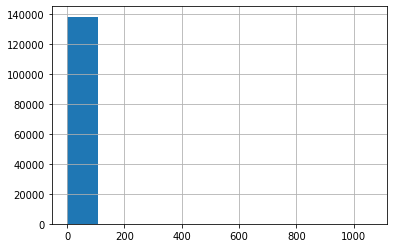

In [111]:
temp['amount'].hist()

The amount in temp is mainly between 0-100. 

In [340]:
#combine the temp with the transcript, and drop 'value' column in transcript.
df = pd.concat([transcript,temp],axis = 1)
df.drop(['value'],axis = 1,inplace = True)
df.head()

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


# Data Pre-processing

The transcript data(df dataframe) is formed in four parts: 
* Only transaction, no offer.
* Offer received.
* Offer viewed.
* Offer completed.

In the following section, I will combine the offer received, offer viewed, offer completed based on the person, offer_id and their transaction time. So we will know which consumer received the offer, whether he/she viewed the offer, and whether he/she completed the offer.  


In [342]:
#change the offer_id to numerical order that is easier to recognize. 
df['offer_id']=df['offer_id'].apply(lambda offer_id:"offer_1" if offer_id == '9b98b8c7a33c4b65b9aebfe6a799e6d9' else
                                         "offer_2" if offer_id == '0b1e1539f2cc45b7b9fa7c272da2e1d7' else
                                         "offer_3" if offer_id == 'ae264e3637204a6fb9bb56bc8210ddfd'else
                                         "offer_4" if offer_id == '2298d6c36e964ae4a3e7e9706d1fb8c2' else
                                         "offer_5" if offer_id == '2906b810c7d4411798c6938adc9daaa5' else
                                         "offer_6" if offer_id == '5a8bc65990b245e5a138643cd4eb9837' else
                                         "offer_7" if offer_id == '3f207df678b143eea3cee63160fa8bed' else
                                         "offer_8" if offer_id == 'fafdcd668e3743c1bb461111dcafc2a4' else
                                         "offer_9" if offer_id == '4d5c57ea9a6940dd891ad53e9dbe8da0' else
                                         "offer_10" if offer_id == 'f19421c1d4aa40978ebb69ca19b0e20d' else
                                         'nan')

In [343]:
df.head()

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,offer_1,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,offer_2,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,offer_5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,offer_8,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,offer_9,NaN


In [344]:
df.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [345]:
df_received = df[df['event'] == 'offer received'] 
df_transaction = df[df['event'] == 'transaction'] 
df_viewed = df[df['event'] == 'offer viewed']
df_completed = df[df['event'] == 'offer completed'] 

In [346]:
df_transaction.amount.isnull().any()

False

The transaction event means the customer doesnot receive any offer, only transaction. 

In [347]:
for name in (df_received, df_viewed,df_completed):
    print(name.offer_id.value_counts())

offer_1     7677
offer_2     7668
offer_3     7658
offer_4     7646
offer_5     7632
offer_6     7618
offer_7     7617
offer_8     7597
offer_9     7593
offer_10    7571
Name: offer_id, dtype: int64
offer_4     7337
offer_8     7327
offer_9     7298
offer_10    7264
offer_3     6716
offer_6     6687
offer_1     4171
offer_7     4144
offer_5     4118
offer_2     2663
Name: offer_id, dtype: int64
offer_8     5317
offer_4     5156
offer_1     4354
offer_10    4296
offer_5     4017
offer_3     3688
offer_2     3420
offer_9     3331
Name: offer_id, dtype: int64


In [371]:
#merge the database of df_received and df_viewed, based on the person and offer_id.
df_new = pd.merge(df_received, df_viewed,  how='left', on=['person', 'offer_id'])

Some consumers received the same offer several times. Since the merge of df_received and df_viewed is based on 'person' and 'offer_id', the consumers who received the same offer more than once will be mergered in different status(received and viewed) under different time. I need to exclude this situation. The way to deal with situation is to get the time difference between the offer received and offer viewed, the smallest time_diff case is the one that paired the offer received and offer viewed. 

In [372]:

df_new['time_diff'] = (df_new['time_x'] - df_new['time_y']).abs()

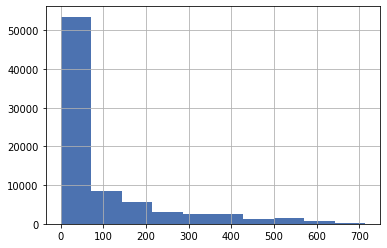

In [373]:
df_new['time_diff'].hist()

The historgram of time_diff shows the some of the offer received and offer viewed is very large which is a clear clue that differen cases are matched toghther, while they are the same conumer and offer. 

In [374]:
#choose the smallest time_diff, which is the paired offer received and offer viewed.
df_new1 = df_new.sort_values("time_diff").groupby(['person','offer_id','time_x'], as_index=False).first()

In [375]:
df_new1.head()

,person,offer_id,time_x,event_x,amount_x,reward_x,event_y,time_y,amount_y,reward_y,time_diff
0,0009655768c64bdeb2e877511632db8f,offer_10,408,offer received,NaN,NaN,offer viewed,456.0,NaN,NaN,48.0
1,0009655768c64bdeb2e877511632db8f,offer_5,576,offer received,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0009655768c64bdeb2e877511632db8f,offer_6,168,offer received,NaN,NaN,offer viewed,192.0,NaN,NaN,24.0
3,0009655768c64bdeb2e877511632db8f,offer_7,336,offer received,NaN,NaN,offer viewed,372.0,NaN,NaN,36.0
4,0009655768c64bdeb2e877511632db8f,offer_8,504,offer received,NaN,NaN,offer viewed,540.0,NaN,NaN,36.0


In [376]:
df_new1.drop(columns = ['amount_x','amount_y','reward_x','reward_y'],inplace = True)

In [385]:
df_new1.count()

person       76277
offer_id     76277
time_x       76277
event_x      76277
event_y      60285
time_y       60285
time_diff    60285
dtype: int64

In [377]:
#merge df_new1 with df_completed based on 'person' and 'offer_id'
df_new2 = pd.merge(df_new1, df_completed,  how='left', on=['person', 'offer_id'])

In [378]:
df_new2.head()

,person,offer_id,time_x,event_x,event_y,time_y,time_diff,event,time,amount,reward
0,0009655768c64bdeb2e877511632db8f,offer_10,408,offer received,offer viewed,456.0,48.0,offer completed,414.0,NaN,5.0
1,0009655768c64bdeb2e877511632db8f,offer_5,576,offer received,NaN,NaN,NaN,offer completed,576.0,NaN,2.0
2,0009655768c64bdeb2e877511632db8f,offer_6,168,offer received,offer viewed,192.0,24.0,NaN,NaN,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,offer_7,336,offer received,offer viewed,372.0,36.0,NaN,NaN,NaN,NaN
4,0009655768c64bdeb2e877511632db8f,offer_8,504,offer received,offer viewed,540.0,36.0,offer completed,528.0,NaN,2.0


The same problem rasied in this merge as the previous merge. So I calcluated the time_diff between the offer completed and offer received, and only choose the smallest time_diff

In [379]:
df_new2['time_diff'] = (df_new2['time'] - df_new2['time_x']).abs()

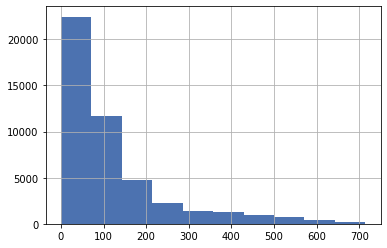

In [380]:
df_new2['time_diff'].hist()

In [381]:
df_new3 = df_new2.sort_values("time_diff").groupby(['person','offer_id','time_x'], as_index=False).first()


In [382]:
df_new3.count()

person       76277
offer_id     76277
time_x       76277
event_x      76277
event_y      60285
time_y       60285
time_diff    35997
event        35997
time         35997
amount           0
reward       35997
dtype: int64

In [386]:
df_new3.drop(columns = ['amount','time_diff'],inplace = True)

In [387]:
df_new3.head()

,person,offer_id,time_x,event_x,event_y,time_y,event,time,reward
0,0009655768c64bdeb2e877511632db8f,offer_10,408,offer received,offer viewed,456.0,offer completed,414.0,5.0
1,0009655768c64bdeb2e877511632db8f,offer_5,576,offer received,NaN,NaN,offer completed,576.0,2.0
2,0009655768c64bdeb2e877511632db8f,offer_6,168,offer received,offer viewed,192.0,NaN,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,offer_7,336,offer received,offer viewed,372.0,NaN,NaN,NaN
4,0009655768c64bdeb2e877511632db8f,offer_8,504,offer received,offer viewed,540.0,offer completed,528.0,2.0


In [388]:
df_new3.rename(columns={'event_x':'offer_received','event_y':'offer_viewed','event':'offer_completed'},inplace = True)

In [389]:
df_new3.rename(columns={'time_x':'time_received','time_y':'time_viewed','time':'time_completed'},inplace = True)

In [390]:
#encode the offer_received, offer_viewed, offer_completed columns.
df_new3['offer_received'] = df_new3['offer_received'].map({'offer received': 1})

In [391]:
df_new3['offer_viewed'] = df_new3['offer_viewed'].map({'offer viewed': 1}).fillna(0)

In [392]:
df_new3['offer_completed'] = df_new3['offer_completed'].map({'offer completed': 1}).fillna(0)

In [393]:
df_new3.head()

,person,offer_id,time_received,offer_received,offer_viewed,time_viewed,offer_completed,time_completed,reward
0,0009655768c64bdeb2e877511632db8f,offer_10,408,1,1.0,456.0,1.0,414.0,5.0
1,0009655768c64bdeb2e877511632db8f,offer_5,576,1,0.0,NaN,1.0,576.0,2.0
2,0009655768c64bdeb2e877511632db8f,offer_6,168,1,1.0,192.0,0.0,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,offer_7,336,1,1.0,372.0,0.0,NaN,NaN
4,0009655768c64bdeb2e877511632db8f,offer_8,504,1,1.0,540.0,1.0,528.0,2.0


In [405]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [406]:
#merge the transcript_cleaned and profile database based on the person column
profile.rename(columns={'id':'person'}, inplace=True)
df_cleaned = df_new3.join(profile.set_index('person'), on='person')

In [531]:
df_cleaned.count()

person              76277
offer_id            76277
time_received       76277
offer_received      76277
offer_viewed        76277
time_viewed         60285
offer_completed     76277
time_completed      35997
reward              35997
gender              66501
age                 76277
became_member_on    76277
income              66501
dtype: int64

In [532]:
#the profile has some missing values, after the merge, we need to drop the missing values in the df_cleaned
df_cleaned.drop(df_cleaned[df_cleaned.income.isnull()].index,inplace = True)
df_cleaned.count()

person              66501
offer_id            66501
time_received       66501
offer_received      66501
offer_viewed        66501
time_viewed         52098
offer_completed     66501
time_completed      34617
reward              34617
gender              66501
age                 66501
became_member_on    66501
income              66501
dtype: int64

In [533]:
df_cleaned.head()

,person,offer_id,time_received,offer_received,offer_viewed,time_viewed,offer_completed,time_completed,reward,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,offer_10,408,1,1.0,456.0,1.0,414.0,5.0,M,33,20170421,72000.0
1,0009655768c64bdeb2e877511632db8f,offer_5,576,1,0.0,NaN,1.0,576.0,2.0,M,33,20170421,72000.0
2,0009655768c64bdeb2e877511632db8f,offer_6,168,1,1.0,192.0,0.0,NaN,NaN,M,33,20170421,72000.0
3,0009655768c64bdeb2e877511632db8f,offer_7,336,1,1.0,372.0,0.0,NaN,NaN,M,33,20170421,72000.0
4,0009655768c64bdeb2e877511632db8f,offer_8,504,1,1.0,540.0,1.0,528.0,2.0,M,33,20170421,72000.0


Since some consumers completed the offer without viewed it. This case should not be counted as validate completed offer. I define the new valid_offer_completed and invalid_offer_completed column to classify this situation.

In [534]:
df_cleaned.dtypes

person               object
offer_id             object
time_received         int64
offer_received        int64
offer_viewed        float64
time_viewed         float64
offer_completed     float64
time_completed      float64
reward              float64
gender               object
age                   int64
became_member_on      int64
income              float64
dtype: object

In [535]:
df_cleaned['offer_completed'] = df_cleaned['offer_completed'].astype(int)
df_cleaned['offer_viewed'] = df_cleaned['offer_viewed'].astype(int)

In [536]:
def valid_offer(row):
    if (row['offer_completed'] == 1) & (row['offer_viewed'] == 1):
        return 1
    else:
        return 0

In [537]:
df_cleaned['valid_offer_completed'] = df_cleaned.apply(lambda row: valid_offer(row), axis = 1)

In [538]:
def invalid_offer(row):
    if (row['offer_completed'] == 1) & (row['offer_viewed'] == 0):
        return 1
    else:
        return 0

In [539]:
df_cleaned['invalid_offer_completed'] = df_cleaned.apply(lambda row: invalid_offer(row), axis = 1)

In [540]:
df_cleaned.head()

,person,offer_id,time_received,offer_received,offer_viewed,time_viewed,offer_completed,time_completed,reward,gender,age,became_member_on,income,valid_offer_completed,invalid_offer_completed
0,0009655768c64bdeb2e877511632db8f,offer_10,408,1,1,456.0,1,414.0,5.0,M,33,20170421,72000.0,1,0
1,0009655768c64bdeb2e877511632db8f,offer_5,576,1,0,NaN,1,576.0,2.0,M,33,20170421,72000.0,0,1
2,0009655768c64bdeb2e877511632db8f,offer_6,168,1,1,192.0,0,NaN,NaN,M,33,20170421,72000.0,0,0
3,0009655768c64bdeb2e877511632db8f,offer_7,336,1,1,372.0,0,NaN,NaN,M,33,20170421,72000.0,0,0
4,0009655768c64bdeb2e877511632db8f,offer_8,504,1,1,540.0,1,528.0,2.0,M,33,20170421,72000.0,1,0


I also need to combine the df_cleaned database with the portfoio which includes the information of the offer. 

In [457]:
portfolio['offer_id'] = portfolio['id'].apply(lambda id:"offer_1" if id == '9b98b8c7a33c4b65b9aebfe6a799e6d9' else
                                         "offer_2" if id == '0b1e1539f2cc45b7b9fa7c272da2e1d7' else
                                         "offer_3" if id == 'ae264e3637204a6fb9bb56bc8210ddfd' else
                                         "offer_4" if id == '2298d6c36e964ae4a3e7e9706d1fb8c2' else
                                         "offer_5" if id == '2906b810c7d4411798c6938adc9daaa5' else
                                         "offer_6" if id == '5a8bc65990b245e5a138643cd4eb9837' else
                                         "offer_7" if id == '3f207df678b143eea3cee63160fa8bed' else
                                         "offer_8" if id == 'fafdcd668e3743c1bb461111dcafc2a4' else
                                         "offer_9" if id == '4d5c57ea9a6940dd891ad53e9dbe8da0' else
                                         "offer_10" if id == 'f19421c1d4aa40978ebb69ca19b0e20d' else
                                         'nan')
portfolio

,reward,channels,difficulty,duration,offer_type,id,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,offer_3
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,offer_9
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,offer_7
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_2
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,offer_4
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,offer_8
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,offer_6
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,offer_10
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,offer_5


In [458]:
portfolio.drop(columns = ['id'],inplace = True)

In [459]:
#check the channels columns in the portfolio
portfolio['channels']

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

In [477]:
#change the channels and offer_type columns into dummy variables
def web(channels):
    if 'web' in channels:
        return 1
    else:
        return 0
    
def email(channels):
    if 'email' in channels:
        return 1
    else:
        return 0

def mobile(channels):
    if 'mobile' in channels:
        return 1
    else: 
        return 0

def social(channels):
    if 'social' in channels:
        return 1
    else:
        return 0
    
def bogo(offer_type):
    if offer_type == 'bogo':
        return 1
    else:
        return 0
def informational(offer_type):
    if offer_type == 'informational':
        return 1
    else:
        return 0
def discount(offer_type):
    if offer_type == 'discount':
        return 1
    else:
        return 0

In [478]:
portfolio['web'] = portfolio['channels'].apply(lambda channels: web(channels))
portfolio['email'] = portfolio['channels'].apply(lambda channels: email(channels))
portfolio['mobile'] = portfolio['channels'].apply(lambda channels: mobile(channels))
portfolio['social'] = portfolio['channels'].apply(lambda channels: social(channels))
portfolio['bogo'] = portfolio['offer_type'].apply(lambda offer_type: bogo(offer_type))
portfolio['informational'] = portfolio['offer_type'].apply(lambda offer_type: informational(offer_type))
portfolio['discount'] = portfolio['offer_type'].apply(lambda offer_type: discount(offer_type))

In [479]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id,web,email,mobile,social,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,offer_3,0,1,1,1,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,offer_9,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,offer_7,1,1,1,0,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,offer_1,1,1,1,0,1,0,0
4,5,"[web, email]",20,10,discount,offer_2,1,1,0,0,0,1,0
5,3,"[web, email, mobile, social]",7,7,discount,offer_4,1,1,1,1,0,1,0
6,2,"[web, email, mobile, social]",10,10,discount,offer_8,1,1,1,1,0,1,0
7,0,"[email, mobile, social]",0,3,informational,offer_6,0,1,1,1,0,0,1
8,5,"[web, email, mobile, social]",5,5,bogo,offer_10,1,1,1,1,1,0,0
9,2,"[web, email, mobile]",10,7,discount,offer_5,1,1,1,0,0,1,0


In [541]:
df_cleaned.drop(columns = ['reward'], inplace = True) 

In [542]:
df_cleaned = df_cleaned.join(portfolio.set_index('offer_id'), on='offer_id')

# Data Visualization

In [488]:
#count the number of the offer_received, viewed, completed, valid completed, invalid completed
offer_received_count = len(df_cleaned[df_cleaned['offer_received'] == 1])
offer_viewed_count = len(df_cleaned[df_cleaned['offer_viewed'] == 1])
offer_completed_count = len(df_cleaned[df_cleaned['offer_completed'] == 1])
valid_offer_completed_count = len(df_cleaned[df_cleaned['valid_offer_completed'] == 1])
invalid_offer_completed_count = len(df_cleaned[df_cleaned['invalid_offer_completed'] == 1])

In [489]:
print(offer_received_count,offer_viewed_count,offer_completed_count,valid_offer_completed_count,invalid_offer_completed_count)

66501 52098 34617 29511 5106


In [490]:
print('The percentage of offer viewed to received is {0:3.2f} '.format(offer_viewed_count/offer_received_count))
print('The percentage of offer completed to reveived is {0:3.2f} '.format(offer_completed_count/offer_received_count))
print('The percentage of offer completed to viewed is {0:3.2f} '.format(offer_completed_count/offer_viewed_count))
print('The percentage of valid offer completed to viewed is {0:3.2f} '.format(valid_offer_completed_count/offer_viewed_count))
print('The percentage of invalid offer completed to viewed is {0:3.2f} '.format(invalid_offer_completed_count/offer_viewed_count))

The percentage of offer viewed to received is 0.78 
The percentage of offer completed to reveived is 0.52 
The percentage of offer completed to viewed is 0.66 
The percentage of valid offer completed to viewed is 0.57 
The percentage of invalid offer completed to viewed is 0.10 


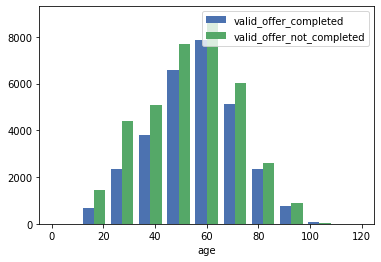

In [491]:
#draw the histogram of age with offer completed and offer not completed.
x = df_cleaned[df_cleaned['valid_offer_completed'] == 1].age
y = df_cleaned[df_cleaned['valid_offer_completed'] == 0].age
bins = np.linspace(0, 120, 12)

plt.hist([x, y], bins, label=['valid_offer_completed', 'valid_offer_not_completed'])
plt.legend(loc='upper right')
plt.xlabel('age')
plt.show()

The age is following the normal distribution, the mean of the age is around 60s. The bar plot of the valid offer completed among different ages shows that the young consumers tend to not complete the offer compared with the older consumers. As the age grows, the consumers are more likely to complete the offer to save money.

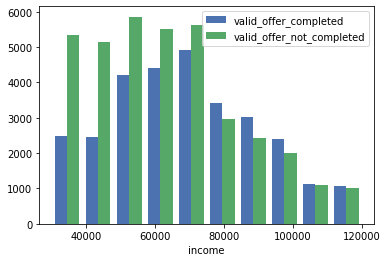

In [492]:
#draw the histogram of income with offer completed and offer not completed.
x = df_cleaned[df_cleaned['valid_offer_completed'] == 1].income
y = df_cleaned[df_cleaned['valid_offer_completed'] == 0].income
#bins = np.linspace(0, 120, 12)

plt.hist([x, y], label=['valid_offer_completed', 'valid_offer_not_completed'])
plt.legend(loc='upper right')
plt.xlabel('income')
plt.show()

The income of the consumers is a left skewed distribution. I found that the low income consumers has a much lower ratio to complete the offer compared with rish consumers. This is coincide with the fact that rich people are more like to save. 

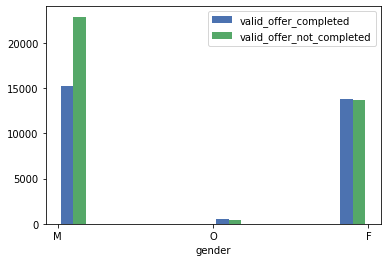

In [517]:
#draw the histogram of gender with offer completed and offer not completed.
x = df_cleaned[df_cleaned['valid_offer_completed'] == 1].gender
y = df_cleaned[df_cleaned['valid_offer_completed'] == 0].gender
#bins = np.linspace(0, 120, 12)

plt.hist([x, y], label=['valid_offer_completed', 'valid_offer_not_completed'])
plt.legend(loc='upper right')
plt.xlabel('gender')
plt.show()

The historgram of gender with valid offer completed shows that female are more likely to finish the offer instead of the male. 

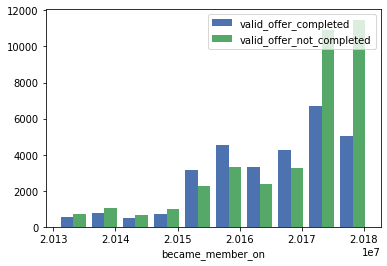

In [494]:
#draw the histogram of became_member_on with offer completed and offer not completed.
x = df_cleaned[df_cleaned['valid_offer_completed'] == 1].became_member_on
y = df_cleaned[df_cleaned['valid_offer_completed'] == 0].became_member_on

#bins = np.linspace(0, 120, 12)

plt.hist([x, y], label=['valid_offer_completed', 'valid_offer_not_completed'])
plt.legend(loc='upper right')
plt.xlabel('became_member_on')
plt.show()

The consumers who become member before 2015 have little low incentive to complete the offer, the consumers who become member between 2015 and 2017 have a high incentive to complete the offer, the consumers who become member after 2017 has much lower incentive to complete the offer. 

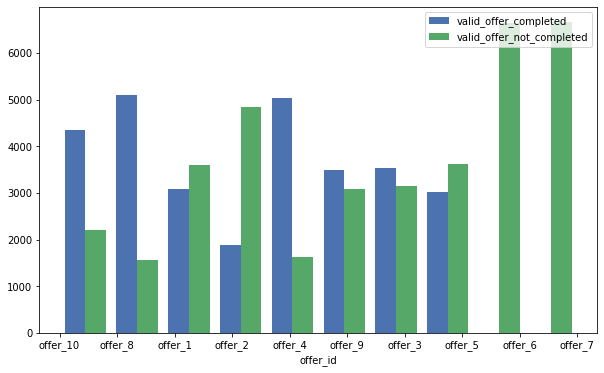

In [500]:
#draw the histogram of offer_id with offer completed and offer not completed.
x = df_cleaned[df_cleaned['valid_offer_completed'] == 1].offer_id
y = df_cleaned[df_cleaned['valid_offer_completed'] == 0].offer_id

#bins = np.linspace(0, 120, 12)
plt.figure(figsize = (10,6))
plt.hist([x, y], label=['valid_offer_completed', 'valid_offer_not_completed'])
plt.legend(loc='upper right')
plt.xlabel('offer_id')
plt.show()

Offer 10, 8, 4 is very popular, lots of consumers would like to finish them. Offer 9, 3 is less popular, but consumers still like to finish it. Offer 1,5 is general, consumers donot like to finish it. Offer 2 is not popular, consumers choose not to finish it most often. Offer 6 and 7 is never finished by any consumers.

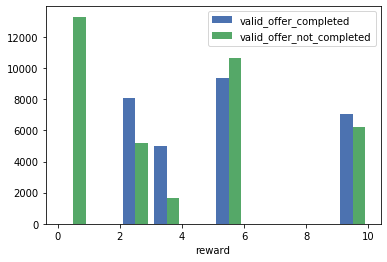

In [496]:
#draw the histogram of reward with offer completed and offer not completed.
x = df_cleaned[df_cleaned['valid_offer_completed'] == 1].reward
y = df_cleaned[df_cleaned['valid_offer_completed'] == 0].reward
#bins = np.linspace(0, 120, 12)

plt.hist([x, y], label=['valid_offer_completed', 'valid_offer_not_completed'])
plt.legend(loc='upper right')
plt.xlabel('reward')
plt.show()

Reward 2 and 4 is very popular. Reward 10 is less popular. Reward 6 is not popular. Reward 0 is never finished. 

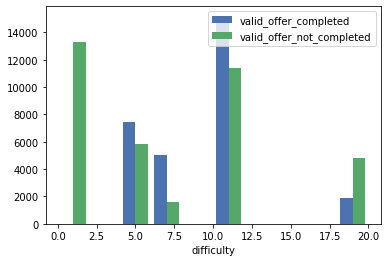

In [498]:
#draw the histogram of difficulty with offer completed and offer not completed.
x = df_cleaned[df_cleaned['valid_offer_completed'] == 1].difficulty
y = df_cleaned[df_cleaned['valid_offer_completed'] == 0].difficulty
#bins = np.linspace(0, 120, 12)

plt.hist([x, y], label=['valid_offer_completed', 'valid_offer_not_completed'])
plt.legend(loc='upper right')
plt.xlabel('difficulty')
plt.show()

In [522]:
df_cleaned[df_cleaned['difficulty'] < 2.5].reward.value_counts()

0    13300
Name: reward, dtype: int64

Median difficulty is acceptable by consumers. Both too easy and too difficulty cause high uncompelted offer, especially the too easy offer. The easy offer with low completion also has a zero reward.

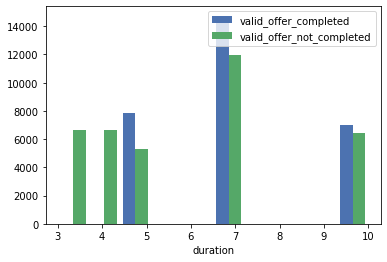

In [502]:
#draw the histogram of duration with offer completed and offer not completed.
x = df_cleaned[df_cleaned['valid_offer_completed'] == 1].duration
y = df_cleaned[df_cleaned['valid_offer_completed'] == 0].duration
#bins = np.linspace(0, 120, 12)

plt.hist([x, y], label=['valid_offer_completed', 'valid_offer_not_completed'])
plt.legend(loc='upper right')
plt.xlabel('duration')
plt.show()

The reasonable duration can stimualte the offer to complete. Short duration results in zero completion.

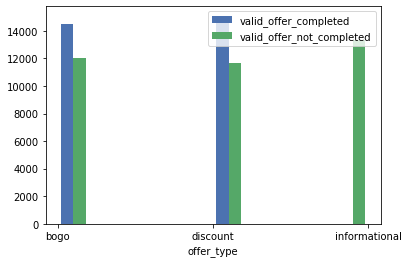

In [503]:
#draw the histogram of offer_type with offer completed and offer not completed.
x = df_cleaned[df_cleaned['valid_offer_completed'] == 1].offer_type
y = df_cleaned[df_cleaned['valid_offer_completed'] == 0].offer_type
#bins = np.linspace(0, 120, 12)

plt.hist([x, y], label=['valid_offer_completed', 'valid_offer_not_completed'])
plt.legend(loc='upper right')
plt.xlabel('offer_type')
plt.show()

Both bogo and discount type offer are more likely to be completed. Informational type offer has zero valid completed. 

In [513]:
df_cleaned[df_cleaned['web'] == 1].groupby(['valid_offer_completed'])['web'].value_counts() 

valid_offer_completed  web
0                      1      27206
1                      1      25969
Name: web, dtype: int64

In [514]:
df_cleaned[df_cleaned['email'] == 1].groupby(['valid_offer_completed'])['email'].value_counts() 

valid_offer_completed  email
0                      1        36990
1                      1        29511
Name: email, dtype: int64

In [515]:
df_cleaned[df_cleaned['mobile'] == 1].groupby(['valid_offer_completed'])['mobile'].value_counts() 

valid_offer_completed  mobile
0                      1         32144
1                      1         27631
Name: mobile, dtype: int64

In [516]:
df_cleaned[df_cleaned['social'] == 1].groupby(['valid_offer_completed'])['social'].value_counts() 

valid_offer_completed  social
0                      1         18278
1                      1         21524
Name: social, dtype: int64

The offers that through 'web', 'email', 'mobile' are all more likely to be not completed. The offer that through 'social' is more likely be completed. 

# Marketing Strategies Analysis

In [523]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id,web,email,mobile,social,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,offer_3,0,1,1,1,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,offer_9,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,offer_7,1,1,1,0,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,offer_1,1,1,1,0,1,0,0
4,5,"[web, email]",20,10,discount,offer_2,1,1,0,0,0,1,0
5,3,"[web, email, mobile, social]",7,7,discount,offer_4,1,1,1,1,0,1,0
6,2,"[web, email, mobile, social]",10,10,discount,offer_8,1,1,1,1,0,1,0
7,0,"[email, mobile, social]",0,3,informational,offer_6,0,1,1,1,0,0,1
8,5,"[web, email, mobile, social]",5,5,bogo,offer_10,1,1,1,1,1,0,0
9,2,"[web, email, mobile]",10,7,discount,offer_5,1,1,1,0,0,1,0


The portfolio dataset shows that offer_6,7 are informational type with zero reward. This explains that the non_completion of offer 6 and 7.

As we analyzed before, there are some conclusions:
* The old people are more likely to finish the offer.
* The high income people are more likely to finish the offer.
* Female is more likely to complete the offer compared with male.
* Customers registered between 2015 and 2017 are more likely fo finish the offer.
* Offer 6 and 7 are never finished by any customers. Offer 10, 8 and 4 are popular.
* The offers with reward under 2 are never finished by any consumers.
* Both too easy and too difficult offers are not popular. The easy offers are the informational type offer 6 and 7. 
* The low duration offer also is never finished, which are offer 6 and 7.
* The informational offers are never completed.
* The offers that through 'web', 'email', 'mobile' are all more likely to be not completed. The offer that through 'social' is more likely be completed. 

As we analyzed before, there are some marketing strategies we can apply:
* No informational offer.
* Send more offer to older people.
* Send more offer to female.
* Send more offer to rich people.
* Send more offer to customers who became member between 2015 and 2017.
* Use social media as the main channel to send out offer. 
* No need to send out offer 6 and 7, since none of them is finished by the customers.

# Machine Learning Analysis

After the visualization analysis, we got a big picture of the marketing strategies, we know which group of people will be the main target of marketing, and we also know what kind of offer is more popular. The next step of this project is to be more specific. We want to know that given a customer with his/her gender, income, membership situation, etc, what kind of offer and in which distribution channel would be completed by him/her. 

In this section, we will apply machine learning methodology into the dataset. I do it in the following steps:
* The records of offer 6 and 7 need to be deleted, since they are never been finished. 
* Select the appropriate features. Change the categorical variables into dummy variables. 
* Seprate the dataset into training and testing set.
* Build machine learning model.
* Tune the model.

In [543]:
df_cleaned.columns

Index(['person', 'offer_id', 'time_received', 'offer_received', 'offer_viewed',
       'time_viewed', 'offer_completed', 'time_completed', 'gender', 'age',
       'became_member_on', 'income', 'valid_offer_completed',
       'invalid_offer_completed', 'reward', 'channels', 'difficulty',
       'duration', 'offer_type', 'web', 'email', 'mobile', 'social', 'bogo',
       'discount', 'informational'],
      dtype='object')

In [544]:
df_final = df_cleaned[df_cleaned['offer_id'] != 'offer_6'] 

In [545]:
df_final = df_final[df_final['offer_id'] != 'offer_7'] 

In [548]:
#choose the features that needed
df_final = df_final.drop(columns = ['person','time_received','offer_received','offer_viewed','time_viewed','time_completed','offer_completed','invalid_offer_completed','channels','offer_type'],axis = 1)

In [549]:
df_final.head()

,offer_id,gender,age,became_member_on,income,valid_offer_completed,reward,difficulty,duration,web,email,mobile,social,bogo,discount,informational
0,offer_10,M,33,20170421,72000.0,1,5,5,5,1,1,1,1,1,0,0
1,offer_5,M,33,20170421,72000.0,0,2,10,7,1,1,1,0,0,1,0
4,offer_8,M,33,20170421,72000.0,1,2,10,10,1,1,1,1,0,1,0
7,offer_1,O,40,20180109,57000.0,1,5,5,7,1,1,1,0,1,0,0
8,offer_2,O,40,20180109,57000.0,1,5,20,10,1,1,0,0,0,1,0


In [554]:
#change the became_member_on to years.
df_final['became_member_on'] = df_final.became_member_on.astype(str).str[:4] 

In [560]:
#encode the offer_id, gender, became_member_on
cat = ['offer_id', 'gender', 'became_member_on']
df_cat= pd.get_dummies(df_final[['offer_id','gender','became_member_on']], prefix = cat, drop_first = True, dummy_na = False)

In [564]:
#change the name of several columns.
df_cat.rename(columns = {'offer_id_offer_8':'offer_8','offer_id_offer_10':'offer_10','offer_id_offer_2':'offer_2','offer_id_offer_3':'offer_3','offer_id_offer_4':'offer_4','offer_id_offer_5':'offer_5','offer_id_offer_9':'offer_9'},inplace = True)


In [571]:
#combine the encoded categrical variables with the numerical variables.
df_model = pd.concat([df_final.drop(columns = ['offer_id', 'gender', 'became_member_on'],axis = 1),df_cat],axis = 1)

In [572]:
df_model.drop(columns = ['bogo','informational'],axis = 1,inplace =True)

In [573]:
#rescale columns: income, age, reward, difficulty,duration.
df_model['income'] = (df_model['income'] -df_model['income'].mean())/(df_model['income'].max() - df_model['income'].min())
df_model['age'] = (df_model['age'] -df_model['age'].mean())/(df_model['age'].max() - df_model['age'].min())
df_model['reward'] = (df_model['reward'] -df_model['reward'].mean())/(df_model['reward'].max() - df_model['reward'].min())
df_model['difficulty'] = (df_model['difficulty'] -df_model['difficulty'].mean())/(df_model['difficulty'].max() - df_model['difficulty'].min())
df_model['duration'] = (df_model['duration'] -df_model['duration'].mean())/(df_model['duration'].max() - df_model['duration'].min())

In [575]:
df_model.describe()

,age,income,valid_offer_completed,reward,difficulty,duration,web,email,mobile,social,...,offer_5,offer_8,offer_9,gender_M,gender_O,became_member_on_2014,became_member_on_2015,became_member_on_2016,became_member_on_2017,became_member_on_2018
count,5.320100e+04,5.320100e+04,53201.000000,5.320100e+04,5.320100e+04,5.320100e+04,53201.000000,53201.0,53201.000000,53201.000000,...,53201.000000,53201.000000,53201.000000,53201.000000,53201.000000,53201.000000,53201.000000,53201.000000,53201.000000,53201.000000
mean,3.567203e-17,7.868714e-18,0.554708,-1.084492e-15,-2.141614e-16,4.704878e-16,0.874382,1.0,0.873574,0.623278,...,0.124641,0.125035,0.123926,0.574463,0.013552,0.044567,0.108043,0.203135,0.376572,0.249225
std,2.094564e-01,2.404342e-01,0.497003,3.734230e-01,2.971920e-01,3.569929e-01,0.331421,0.0,0.332332,0.484569,...,0.330314,0.330762,0.329500,0.494429,0.115624,0.206353,0.310438,0.402336,0.484531,0.432568
min,-4.376098e-01,-3.930177e-01,0.000000,-4.060638e-01,-3.095117e-01,-4.518637e-01,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.484531e-01,-1.819066e-01,0.000000,-2.810638e-01,-1.761784e-01,-5.186369e-02,1.000000,1.0,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.173368e-03,-1.523990e-02,1.000000,-3.106380e-02,2.382161e-02,-5.186369e-02,1.000000,1.0,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.407035e-01,1.625379e-01,1.000000,-3.106380e-02,2.382161e-02,5.481363e-01,1.000000,1.0,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,5.623902e-01,6.069823e-01,1.000000,5.939362e-01,6.904883e-01,5.481363e-01,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [576]:
#Define the regression model X and y
X = df_model.drop(columns = ['valid_offer_completed'],axis = 1)
y = df_model['valid_offer_completed']

In [578]:
#Use train_test_split to split the data set into train and test. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [583]:
#logistic regression
lr = LogisticRegression()
clf = lr.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [584]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[4288, 2768],
       [2236, 6669]])

In [585]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.686485809159827
Precision: 0.7066864469640776
Recall: 0.7489051094890511


In [587]:
# Apply the random forest classification model
rf = RandomForestClassifier()

In [588]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [590]:
y_pred = rf.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[4765, 2291],
       [2099, 6806]])

In [591]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7249545767809035
Precision: 0.7481587336484555
Recall: 0.7642897248736665


In [596]:
#I will use randomizesearch cross validation to find best random forest model for this problem

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 10)]
# Number of features to consider at every split
max_features = ['auto', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(30, 100, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
from pprint import pprint
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [30, 37, 44, 51, 58, 65, 72, 79, 86, 93, 100, None],
 'max_features': ['auto', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10, 15],
 'n_estimators': [100, 133, 166, 200, 233, 266, 300, 333, 366, 400]}


In [601]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 75.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [602]:
rf_random.best_params_


{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 37,
 'bootstrap': True}

In [603]:
best_random = rf_random.best_estimator_

y_pred = best_random.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[4768, 2288],
       [2005, 6900]])

In [604]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7310318902324415
Precision: 0.7509795385285154
Recall: 0.7748455923638405
